In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train dimension:  (30, 455)
y_train dimension:  (1, 455)


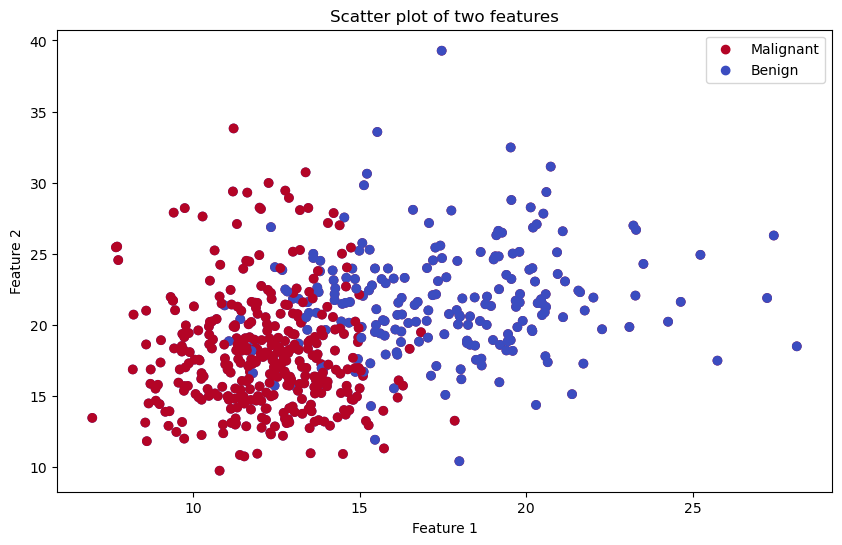

In [2]:
data_train = pd.read_csv('data.csv', header=None)

X = data_train.iloc[:, 2:].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

y = data_train.iloc[:, 1].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = y.reshape(y.shape[0], 1)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

print('X_train dimension: ', X_train.shape)
print('y_train dimension: ', y_train.shape)

# print('X: ', X)
# print('y: ', y)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=(y == 1), cmap='coolwarm', label='Malignant')
plt.scatter(X[:, 0], X[:, 1], c=(y == 0), cmap='coolwarm', label='Benign')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter plot of two features')
plt.legend()
plt.show()

In [3]:
def init(dimensions):
    # dimensions is list containing the number of neurons in each layer
    # meaning that its length is the number of layers
    # ie. dimensions = [2, 32, 32, 1] means 2 input features, 32 neurons in both hidden layers, 1 output neuron

    parameters = {}
    layer = len(dimensions)

    for l in range(1, layer):
        # create random weights and bias for each layer (W1, b1, W2, b2, ...)
        parameters['W' + str(l)] = np.random.randn(dimensions[l], dimensions[l - 1])
        parameters['b' + str(l)] = np.random.randn(dimensions[l], 1)

    return parameters

# parameters = init([30, 32, 32, 1])

# for key, value in parameters.items():
#     print(key, value.shape)

In [4]:
def forward_propagation(X, parameters):

    activations = {'A0' : X}

    hidden_layer = len(parameters) // 2

    for l in range(1, hidden_layer + 1):
        Z = np.dot(parameters['W' + str(l)], activations['A' + str(l - 1)]) + parameters['b' + str(l)]
        activations['A' + str(l)] = 1 / (1 + np.exp(-Z))

    return activations

# activations = forward_propagation(X_train, parameters)

# for key, value in activations.items():
#     print(key, value.shape)

In [5]:
def loss(y, A):
    epsilon = 1e-15 # Small value to avoid log(0)
    L = 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))
    return L

In [6]:
def back_propagation(y, activations, parameters):

    gradients = {}

    m = y.shape[1]
    hidden_layer = len(parameters) // 2
    dZ = activations['A' + str(hidden_layer)] - y
    
    for l in reversed(range(1, hidden_layer + 1)):
        gradients['dW' + str(l)] = 1 / m * np.dot(dZ, activations['A' + str(l - 1)].T)
        gradients['db' + str(l)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        # for c > 1, calculate dZ for the next iteration
        if l > 1:
            dZ = np.dot(parameters['W' + str(l)].T, dZ) * activations['A' + str(l - 1)] * (1 - activations['A' + str(l - 1)])
    
    return gradients

# gradients = back_propagation(y_train, activations, parameters)

# for key, value in gradients.items():
#     print(key, value.shape)

In [7]:
def update(gradients, parameters, learning_rate):
    
    hidden_layer = len(parameters) // 2

    for l in range(1, hidden_layer + 1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * gradients['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * gradients['db' + str(l)]

    return parameters

In [8]:
def predict(X, parameters):
    activations = forward_propagation(X, parameters)
    hidden_layer = len(parameters) // 2
    A = activations['A' + str(hidden_layer)]
    return A >= 0.5

In [9]:
def train(X_train, y_train, X_test, y_test, hidden_layers = (32, 32, 32), learning_rate = 0.01, epochs = 10000):
    
    np.random.seed(42)

    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(y_train.shape[0])

    parameters = init(dimensions)
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for i in tqdm(range(epochs)):
        
        activations = forward_propagation(X_train, parameters)
        activations_test = forward_propagation(X_test, parameters)
        gradients = back_propagation(y_train, activations, parameters)
        parameters = update(gradients, parameters, learning_rate)
        
        if (i % 10 == 0):
            L = len(parameters) // 2
            train_loss.append(loss(y_train, activations['A' + str(L)]))
            y_pred = predict(X_train, parameters)
            train_acc.append(accuracy_score(y_train.flatten(), y_pred.flatten()))

            test_loss.append(loss(y_test, activations_test['A' + str(L)]))
            y_test_pred = predict(X_test, parameters)
            test_acc.append(accuracy_score(y_test.flatten(), y_test_pred.flatten()))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train accuracy')
    plt.plot(test_acc, label='test accuracy')
    plt.legend()
    plt.show()
    return parameters

100%|██████████| 10000/10000 [00:17<00:00, 558.15it/s]


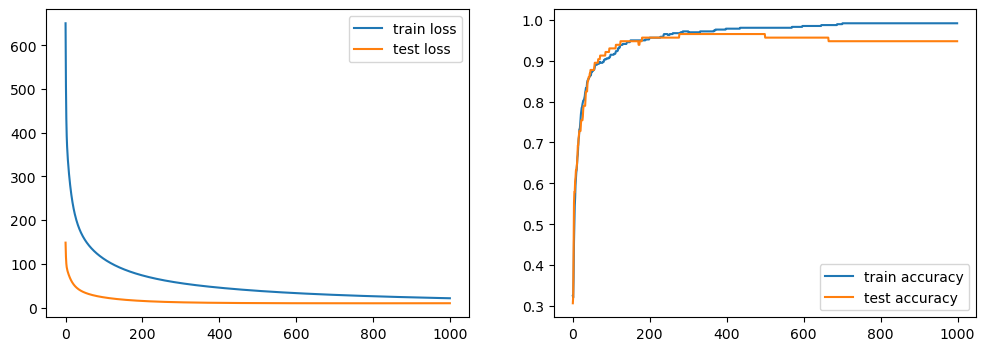

In [10]:
parameters = train(X_train, y_train, X_test, y_test)